# Project Title Here

**Names**: Group member names here

You can delete and add as many code blocks as you like or change the formatting.

## 1. Introduction and Dataset Research

### 1.1 Motivation

Since the Covid-19 pandemic, 1 out of 5 US worker has considered changing job or fields [1]. In this rapidly changing technology sector, keeping yourself updated with the right skills is important. According to world economic forum, 50% of all employees will need to upskill in order to be relevant in their current position. [2] The LinkedIn career explorer allows users to choose thier current field and their target field and provides the report on how many skills overlap. [3]<font color='orange'> Add more.

### 1.2 <font color='orange'> Research Goals
    
1. What are the top skills required for different job categories?
    
2. How different job categories are related to each other and what are the shared skills?
    
3. If someone wants to switch to a different career journey, which one would be easier to switch?
        
### 1.3 References:
    
1. <font color='orange'> APA format https://6abc.com/career-tips-job-training-software-engineering-changing/11224887/
    
2. <font color='orange'> APA format    https://www.fastcompany.com/90675619/want-to-future-proof-your-career-prepare-to-invent-yourself
    
3. <font color='orange'> APA format https://linkedin.github.io/career-explorer/

### 1.4 Dataset Information

* The dataset has 1222 Facebook job posting text out of which 681 are unique job postings. The textual data is scraped from Faceboook's career page. The links to the actual job posting is also included in one column.

Below is the data dictionary:

> category: job category ('Product Management', 'Research Scientist', 'Data and Analytics',
       'Business Development & Partnerships', 'Software Engineering',
       'People & Recruiting', 'Global Operations')
       
> company: Facebook

> title: 686 unique job titles

> description: Brief description of job and responsibilities.

> basic_qualifications: Basic qualifications required for the job

> preferred_qualifications: Preferred qualifications required for the job

> country: US

> state: ['CA', 'WA', 'TX', 'US', 'NY', 'DC', 'CO', 'PA']

> qualifications: combination of basic qualification and preferred qualifications

## 2. Data Cleaning and Data Manipulation

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from sklearn.manifold import TSNE
import nltk
import re
import seaborn as sns
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem import WordNetLemmatizer

### 2.1 Reading Input file

In [27]:
df = pd.read_excel('job_data.xlsx')
df_raw = df.copy()

### 2.2 Dropping unnecessary columns

In [28]:
df = df.drop(columns=['Unnamed: 0', 'location_and_id', 'posting_date', 'country_name',
                      'alpha_2', 'alpha_3', 'un_code', 'link', 'city', 'job_id'])
df = df[df.company=='Facebook']
df.head(3)

,category,company,title,description,basic_qualifications,preferred_qualifications,country,state,qualifications
12443,Product Management,Facebook,Product Manager - Consumer Software (Facebook ...,"Lead the ideation, technical development, and ...",3+ years product management experience or simi...,"Experience developing social products, technol...",US,CA,3+ years product management experience or simi...
12444,Product Management,Facebook,Product Manager - Platform (Facebook Reality L...,"Lead the ideation, technical development, and ...",4+ years product management experience with 2+...,Experience working on a successful developer a...,US,CA,4+ years product management experience with 2+...
12445,Product Management,Facebook,Product Manager,"Display strong leadership, organizational and ...",5+ years product management or related industr...,Experience of going through a full product lif...,US,CA,5+ years product management or related industr...


In [29]:
df.shape

(1222, 9)

- There are some duplicate job qualifications, hence, lets drop these duplicates.

In [41]:
df = df.drop_duplicates(subset='qualifications', keep="last")
df = df.reset_index(drop=True)

In [42]:
df.shape

(727, 9)

In [43]:
df.isna().sum()

category                     0
company                      0
title                        0
description                  0
basic_qualifications         0
preferred_qualifications    77
country                      0
state                        0
qualifications               0
dtype: int64

- Originally, there were 19 columns out of which only 9 are useful. Hence, the other columns are dropped.

- There are no missing values except 77 preferred qualifications. Since these jobs do not have provided preferred qualifications, and we are combining all qualifications in qualfications column, it won't affect our analysis.

### 2.3 Vectorizing the text corpus

In [44]:
# we need remove stopwords from text, let's use nltk's English stopwords.
stpwords = stopwords.words('english')

In [64]:
# lemmatizer = WordNetLemmatizer()
# stemmer = SnowballStemmer("english")
# lemmatizer.lemmatize('challenging')
# stemmer.stem('challenging')

In [89]:
def tokenization_and_lemma(text):
    # Remove punctuation characters and numbers
    text = re.sub(r"[^a-zA-Z]", " ", text)
    
    # Tokenize text
    tokens = word_tokenize(text)
    
    # Create a instance of stem class
    # stemmer = SnowballStemmer("english")
    # we will use lemmatization instead of stemming in order to retain meaning to the words
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for word in tokens:
        # clean_tok = stemmer.stem(word).lower().strip()
        clean_tok = lemmatizer.lemmatize(word).lower().strip()

        if clean_tok not in stpwords:
            clean_tokens.append(clean_tok)

    return clean_tokens

In [90]:
data_description = df.loc[:, 'description'].tolist()
data_qualification = df.loc[:, 'qualifications'].tolist()

In [91]:
tfidf_model_description = TfidfVectorizer(
    max_df=0.99, # max_df : maximum document frequency for the given word
    max_features=1000, # max_features: maximum number of words
    min_df=0.01, # min_df : minimum document frequency for the given word
    use_idf=True, # use_idf: if not true, we only calculate tf
    tokenizer=tokenization_and_lemma,
    ngram_range=(1,2) # ngram_range: (min, max), eg. (1, 2) including 1-gram, 2-gram
)

tfidf_model_qualifications = TfidfVectorizer(
    max_df=0.99, # max_df : maximum document frequency for the given word
    max_features=1000, # max_features: maximum number of words
    min_df=0.01, # min_df : minimum document frequency for the given word
    use_idf=True, # use_idf: if not true, we only calculate tf
    tokenizer=tokenization_and_lemma,
    ngram_range=(1,2) # ngram_range: (min, max), eg. (1, 2) including 1-gram, 2-gram
)

In [92]:
# Fit the TfidfVectorizer to our data
tfidf_matrix_description = tfidf_model_description.fit_transform(data_description)
tfidf_matrix_qualifications = tfidf_model_qualifications.fit_transform(data_qualification)

# words
tf_selected_words_desc = tfidf_model_description.get_feature_names()
tf_selected_words_qual = tfidf_model_qualifications.get_feature_names()

# data matrix
tfidf_matrix_np_desc = tfidf_matrix_description.toarray()
tfidf_matrix_np_qual = tfidf_matrix_qualifications.toarray()

In [93]:
tf_selected_words_desc[-1]

'world class'

In [94]:
tf_selected_words_qual[-1]

'year work'

## 3. Basic Descriptive Analytics

### 3.1 Visualizing distribution of pre-assigned class labels

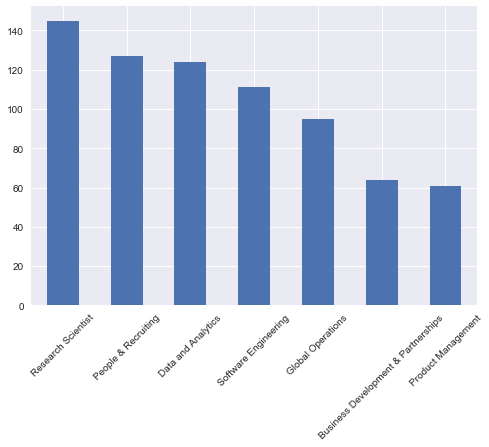

In [106]:
df.category.value_counts().plot(kind='bar')
plt.xticks(rotation=45)
plt.show()

In [113]:
pd.DataFrame(tfidf_matrix_np_desc, columns=tf_selected_words_desc).describe()

,ability,ability travel,able,abuse,account,accountability,accurate,achieve,across,across company,...,within,work,work across,work closely,work cross,workflow,workforce,working,world,world class
count,727.000000,727.000000,727.000000,727.000000,727.00000,727.000000,727.000000,727.000000,727.000000,727.000000,...,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000
mean,0.007520,0.002843,0.003777,0.003263,0.00294,0.003494,0.003619,0.006894,0.030337,0.006809,...,0.009460,0.032106,0.002776,0.011658,0.008840,0.007685,0.004352,0.010659,0.008083,0.006347
std,0.027263,0.016818,0.022989,0.029021,0.02092,0.020719,0.026095,0.030013,0.043206,0.027602,...,0.030470,0.044199,0.018156,0.034330,0.029571,0.037217,0.030756,0.032263,0.028237,0.026136
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.054580,0.000000,...,0.000000,0.054088,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.221092,0.136955,0.266051,0.382457,0.29338,0.194424,0.250019,0.209647,0.204425,0.214089,...,0.229958,0.280282,0.182242,0.203297,0.199016,0.362059,0.440662,0.221850,0.207799,0.204018


## 4. Dataset Scaling Decisions

Since we have used tf-idf vectorizer to convert raw text into vectorized form, all columns have range [0, 1]. Hence we do not need to perform scaling.

## 5. Clusterability and Clustering Structure Questions

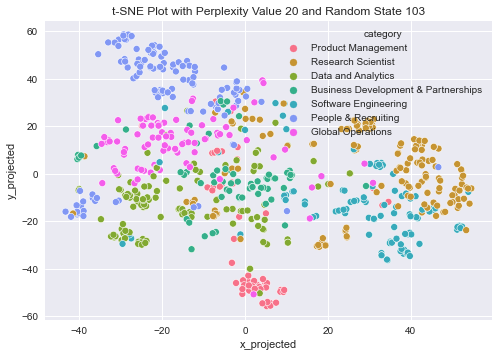

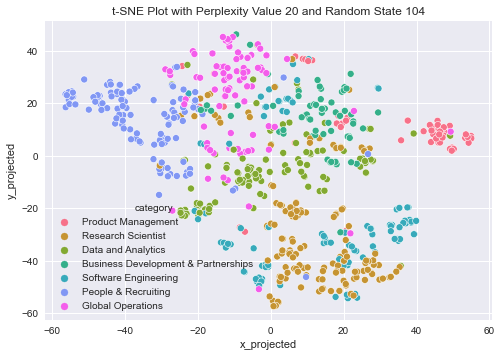

--------------------------------------------


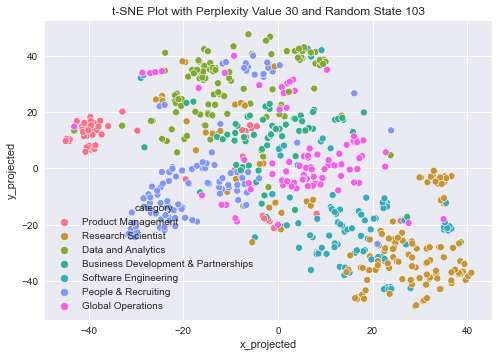

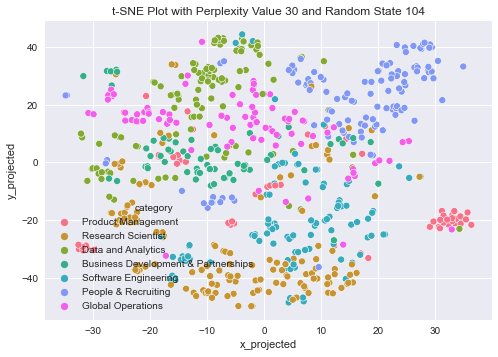

--------------------------------------------


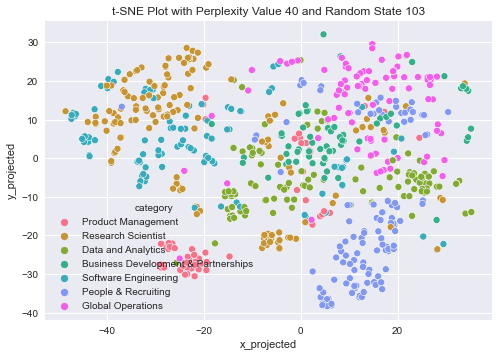

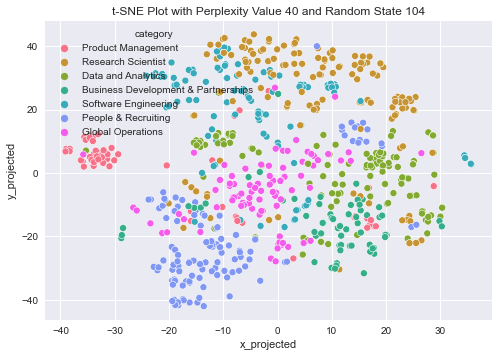

--------------------------------------------


In [95]:
for perp in [20, 30, 40]:
    for rs in [103,104]:
        tsne = TSNE(n_components=2, perplexity=perp, random_state=rs)
        data_tsne = tsne.fit_transform(tfidf_matrix_np_desc)
        df_tsne = pd.DataFrame(data_tsne, columns=['x_projected', 'y_projected'])
        df_combo = pd.concat([df, df_tsne], axis=1)
        sns.scatterplot(x='x_projected',y='y_projected', hue='category', palette=sns.color_palette("husl", 7), data=df_combo)
        plt.title('t-SNE Plot with Perplexity Value %s and Random State %s' %(perp, rs))
#         plt.legend(bbox_to_anchor=(1,1))
        plt.show()
    print('--------------------------------------------')

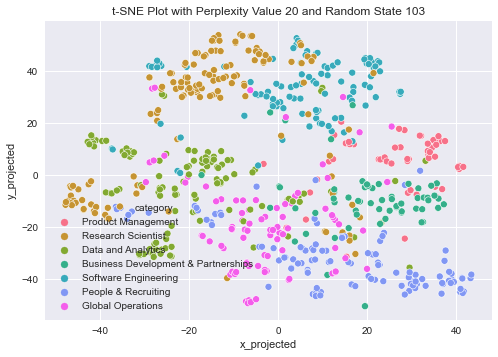

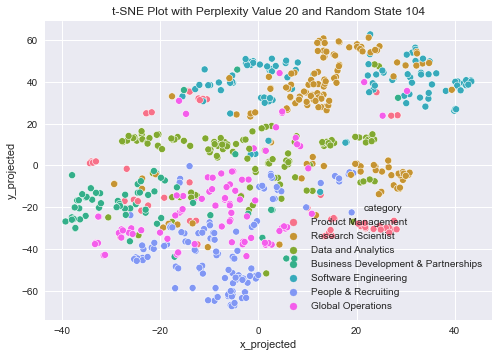

--------------------------------------------


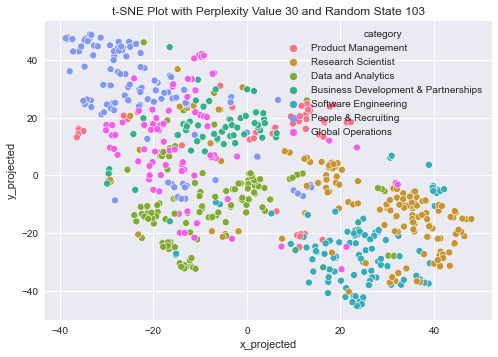

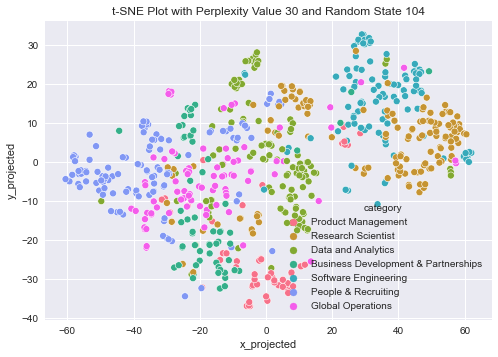

--------------------------------------------


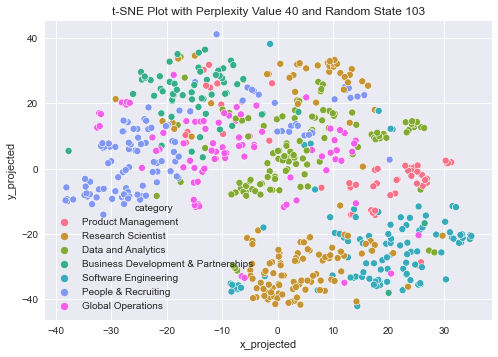

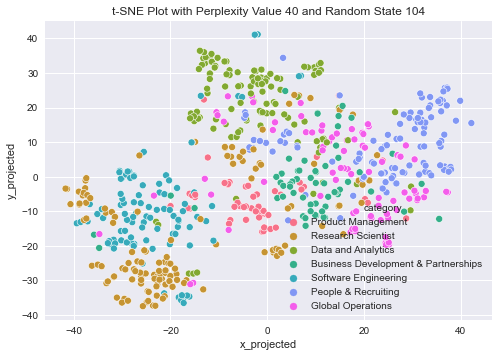

--------------------------------------------


In [96]:
for perp in [20, 30, 40]:
    for rs in [103,104]:
        tsne = TSNE(n_components=2, perplexity=perp, random_state=rs)
        data_tsne = tsne.fit_transform(tfidf_matrix_np_qual)
        df_tsne = pd.DataFrame(data_tsne, columns=['x_projected', 'y_projected'])
        df_combo = pd.concat([df, df_tsne], axis=1)
        sns.scatterplot(x='x_projected',y='y_projected', hue='category', palette=sns.color_palette("husl", 7), data=df_combo)
        plt.title('t-SNE Plot with Perplexity Value %s and Random State %s' %(perp, rs))
#         plt.legend(bbox_to_anchor=(1,1))
        plt.show()
    print('--------------------------------------------')

## 6. Algorithm Selection Motivation

- Based on t-SNE plot, we can see for the same job category, there are small clusters at different proximity. Hence, this suggests that a hierarchical clustering algorithm may be able to identify such levels.

- Also, we want to understand which are the dominant words in each of the job category to understand the top skills that are required. This suggests that using Latent Dirichlet Algorithms (LDA) can be a good option.

## 7. Clustering Algorithm 1 (change name to the algorithm you chose)



### 7.1. Parameter Selection

### 7.2. Clustering Algorithm

### 7.3. Clustering Algorithm Results Presentation

### 7.4. Assessing Clustering Separation and Cohesion

### 7.5. Additional Analysis

### 7.6. Describing Each of the Clusters

## 8. Clustering Algorithm 2 (change name to the algorithm you chose)



### 8.1. Parameter Selection

### 8.2. Clustering Algorithm

### 8.3. Clustering Algorithm Results Presentation

### 8.4. Assessing Clustering Separation and Cohesion

### 8.5. Additional Analysis

### 8.6. Describing Each of the Clusters

## 9. Analysis Summary and Conclusion

### 9.1. Algorithm Comparison Summary

#### 9.1.1. Comparing Algorithm Performance

#### 9.1.2. Comparing Algorithm Results

### 9.2. Conclusion and Insights Summary

## 10. Group Contribution Report